In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
pd.set_option("display.max_columns",None)
pd.set_option("display.max_row",200)

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
# to perform PCA
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount ("/content/drive")
path = ("/content/drive/MyDrive/Unsupervised learning project 6/Credit Card Customer Data.xlsx")
data = pd.read_excel(path)

Mounted at /content/drive


In [4]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
data.shape

(660, 7)

In [6]:
da=data.copy()

In [7]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [8]:
da.duplicated().sum()

0

In [9]:
da.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [10]:
da['Customer Key'].nunique()

655

In [11]:
da['Sl_No'].nunique()

660

In [12]:
da[da['Customer Key'].duplicated(keep=False)]


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
48,49,37252,6000,4,0,2,8
104,105,97935,17000,2,1,2,10
332,333,47437,17000,7,3,1,0
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
411,412,50706,44000,4,5,0,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


In [13]:
#hence "Customer key" doesnt have unique values for all rows where "Sl_No" has uniques values for all rows so we are keeping "Sl_No" and droping "Customer key".

In [14]:
da.drop("Customer Key",axis=1, inplace=True)

In [15]:
da.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [16]:
da.isna().sum()

,0
Sl_No,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


In [17]:
#univariate analysis

In [18]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid = 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots

    # Boxplot
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    # Set title for the boxplot
    ax_box2.set_title(f'Distribution of {feature}', fontsize=16)

    # Histogram
    if bins:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins)
    else:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)

    # Add mean and median to histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )



In [19]:
da.head()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,100000,2,1,1,0
1,2,50000,3,0,10,9
2,3,50000,7,1,3,4
3,4,30000,5,1,1,4
4,5,100000,6,0,12,3


In [20]:
da['Sl_No'] = da['Sl_No'].astype('category')

In [21]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Sl_No                660 non-null    category
 1   Avg_Credit_Limit     660 non-null    int64   
 2   Total_Credit_Cards   660 non-null    int64   
 3   Total_visits_bank    660 non-null    int64   
 4   Total_visits_online  660 non-null    int64   
 5   Total_calls_made     660 non-null    int64   
dtypes: category(1), int64(5)
memory usage: 48.5 KB


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


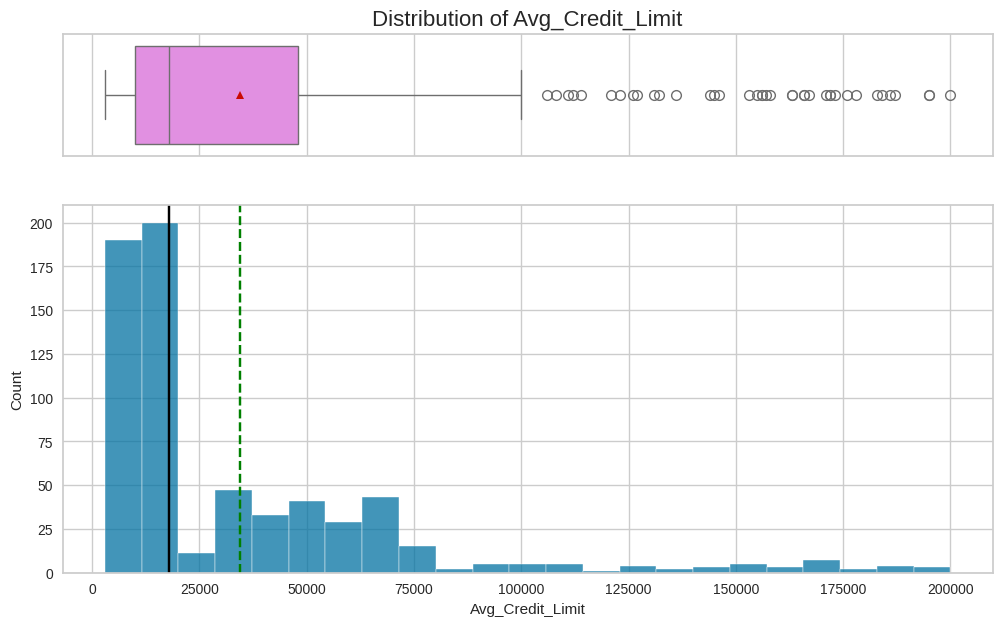

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


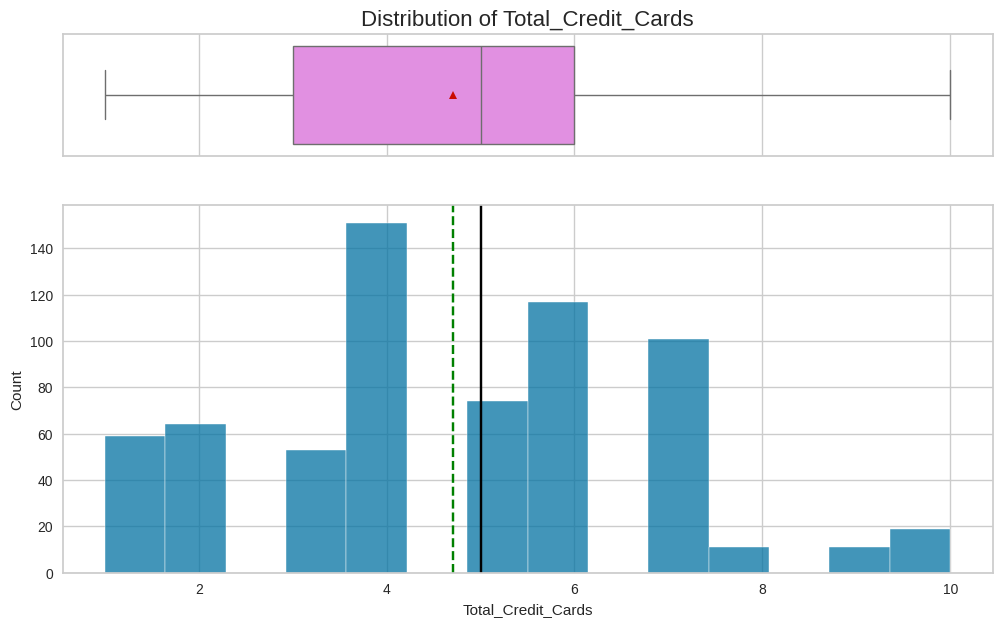

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


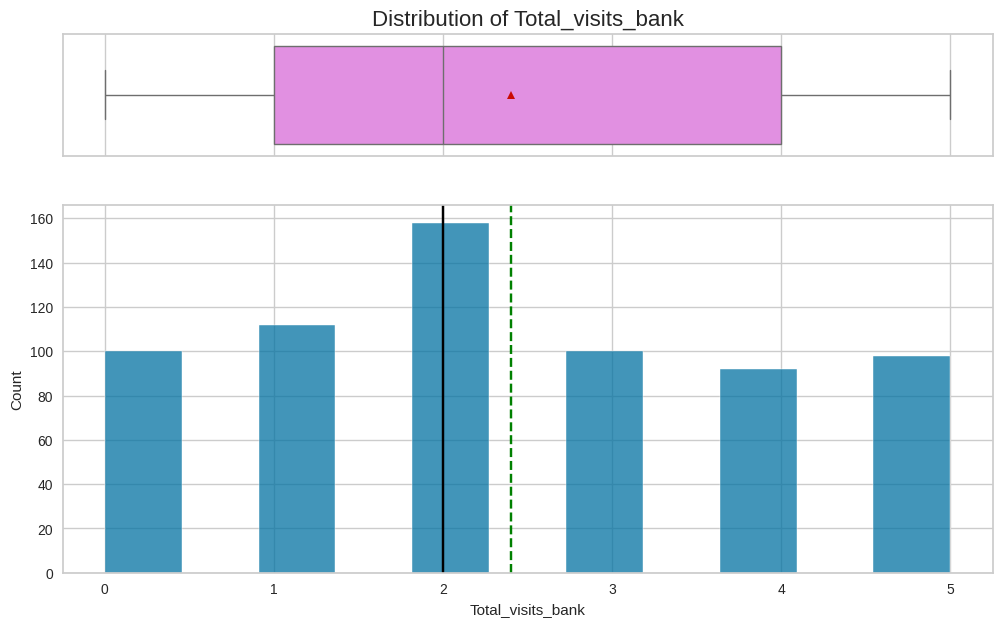

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


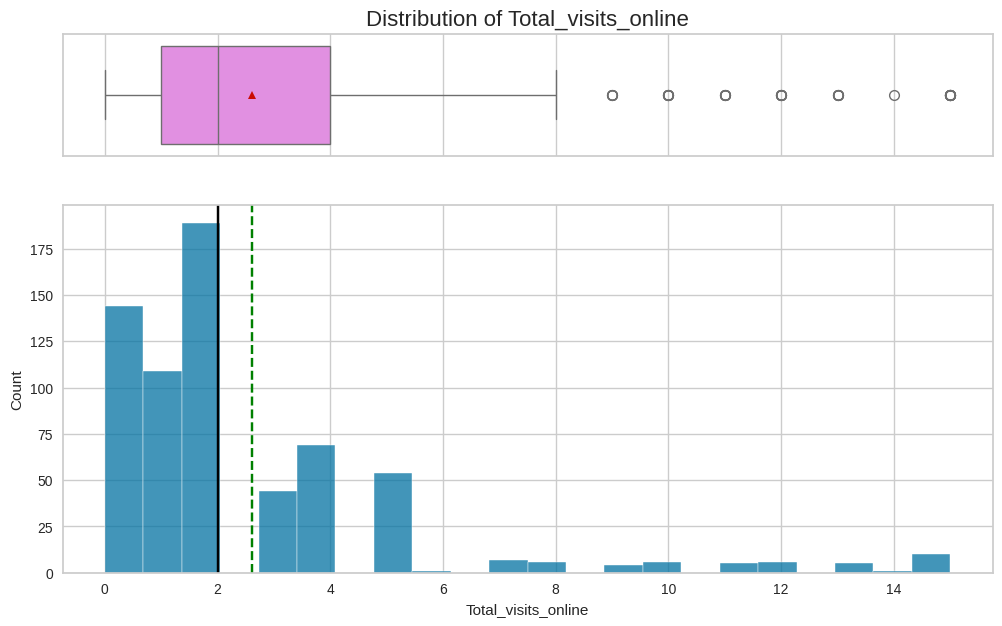

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


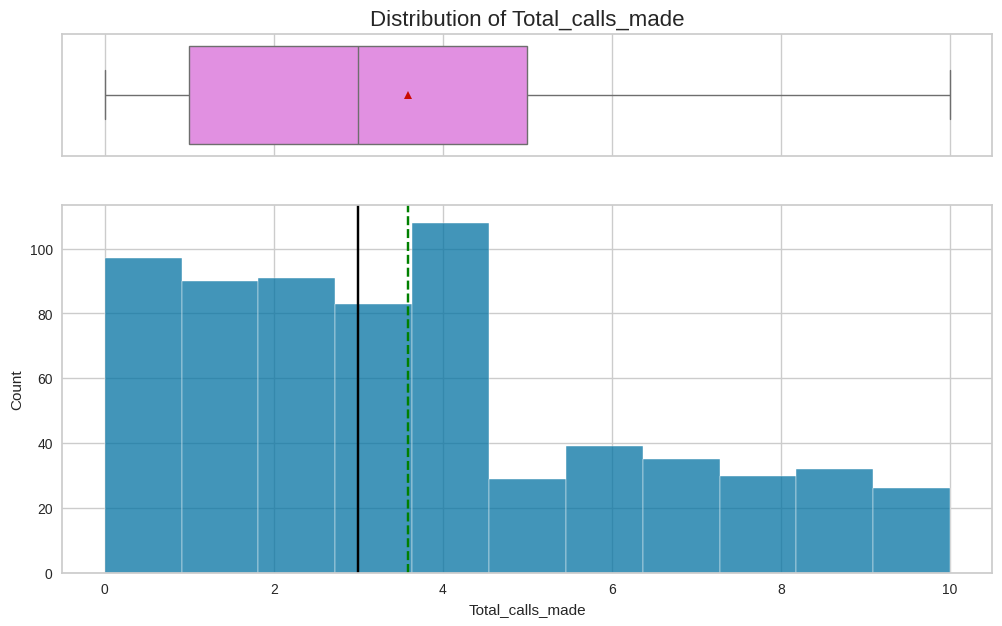

In [22]:
num_col = da.select_dtypes(include=np.number).columns.tolist()
for item in num_col:
    histogram_boxplot(da, item)
    print("-"*200)
    plt.show()

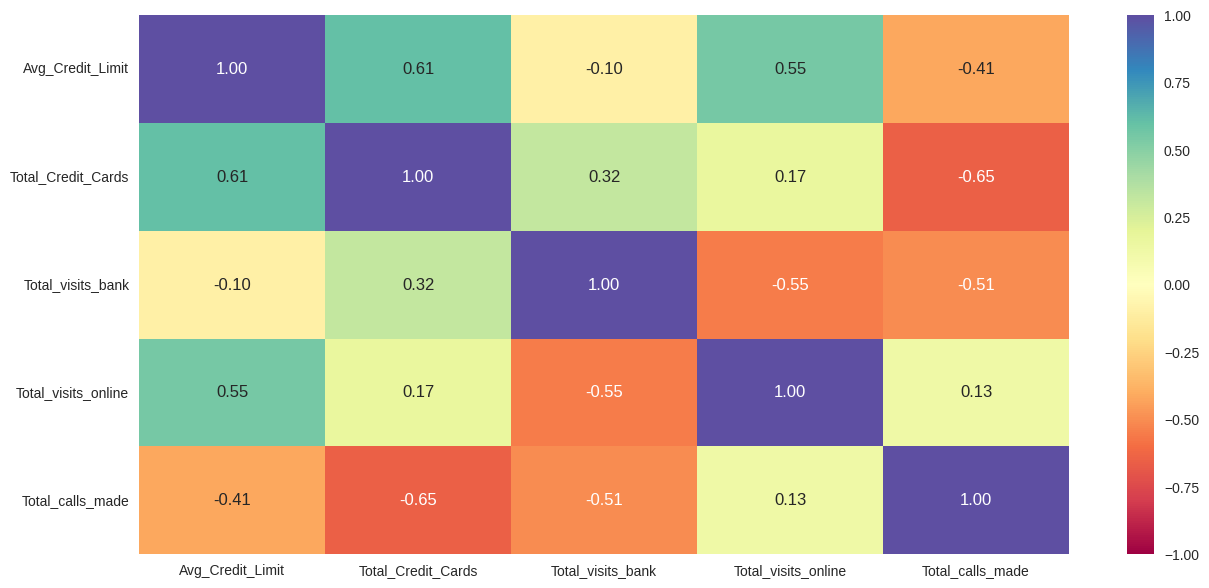

In [23]:


# Generate correlation matrix for numeric columns only
plt.figure(figsize=(15, 7))
sns.heatmap(da[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()


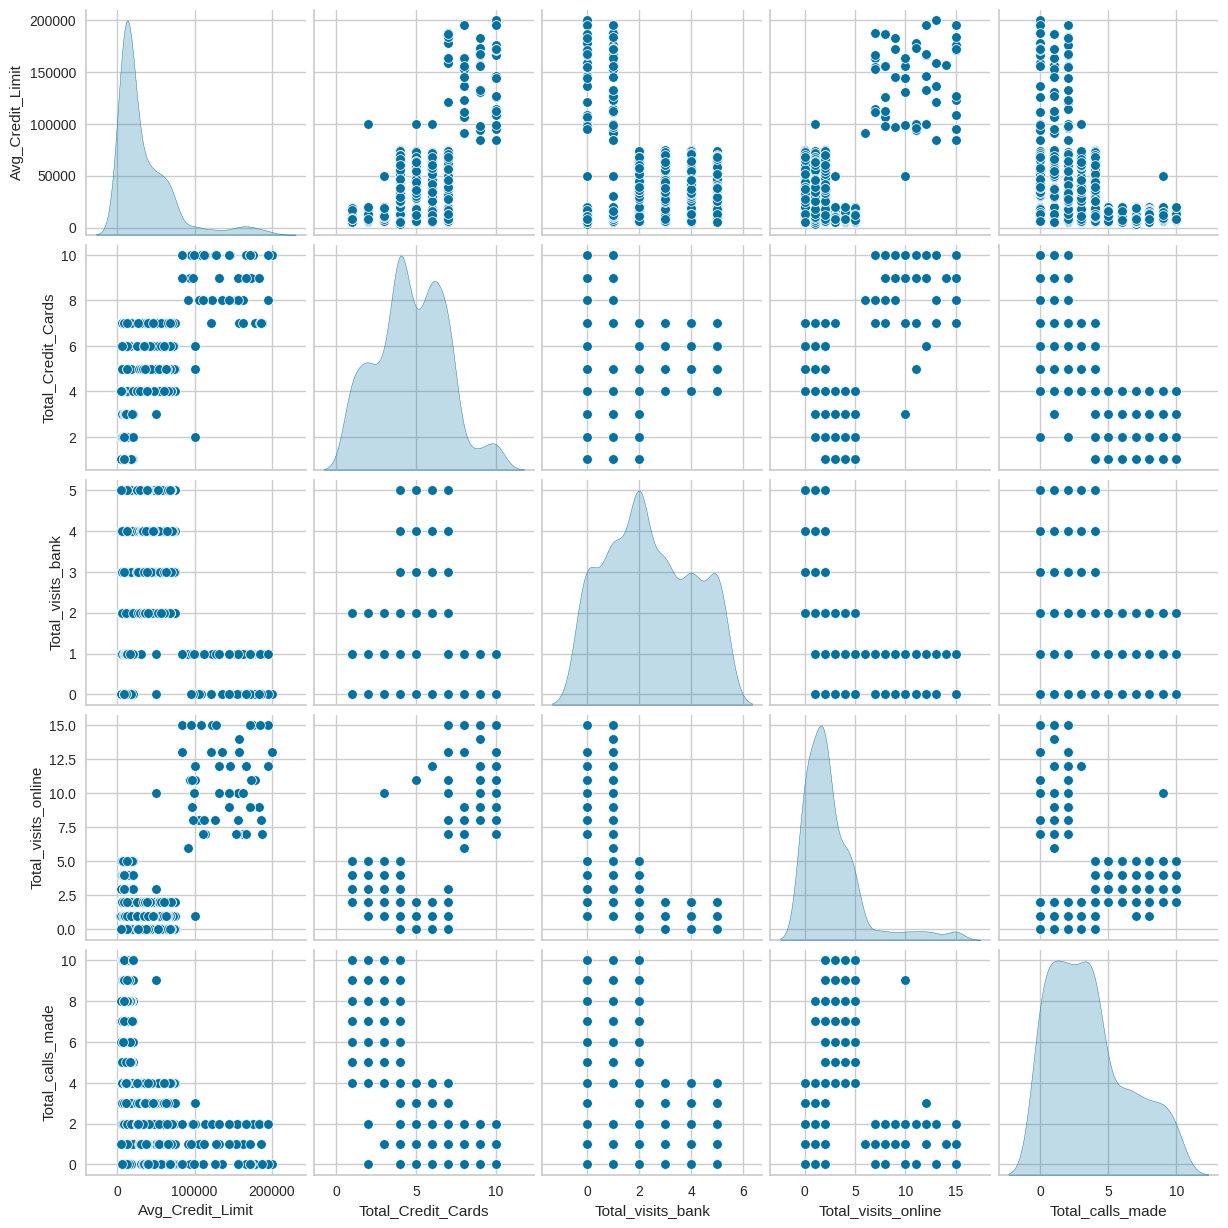

In [24]:
sns.pairplot(data=da[num_col], diag_kind="kde")
plt.show()

In [25]:
#freture enginner

In [26]:
da['Total_visits'] = da['Total_visits_bank'] + da['Total_visits_online']

In [27]:
da = da.drop(columns=['Total_visits_online', 'Total_visits_bank'])

In [28]:
num_col = da.select_dtypes(include=np.number).columns.tolist()

In [29]:
da[num_col].corr()['Total_visits'].sort_values(ascending=False)

,Total_visits
Total_visits,1.000000
Avg_Credit_Limit,0.594315
Total_Credit_Cards,0.411649
Total_calls_made,-0.184626


In [30]:
da.head()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits
0,1,100000,2,0,2
1,2,50000,3,9,10
2,3,50000,7,4,4
3,4,30000,5,4,2
4,5,100000,6,3,12


In [31]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Sl_No               660 non-null    category
 1   Avg_Credit_Limit    660 non-null    int64   
 2   Total_Credit_Cards  660 non-null    int64   
 3   Total_calls_made    660 non-null    int64   
 4   Total_visits        660 non-null    int64   
dtypes: category(1), int64(4)
memory usage: 43.4 KB


In [32]:
# outliers treatment

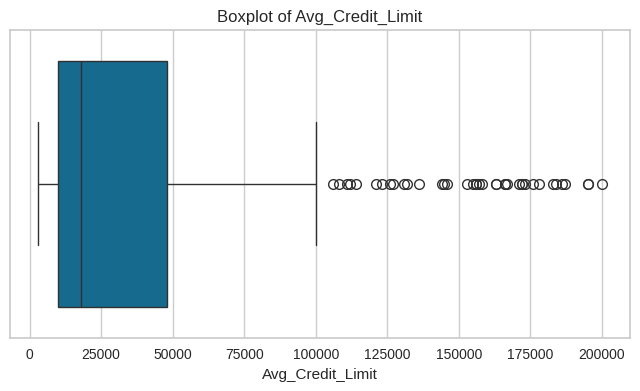

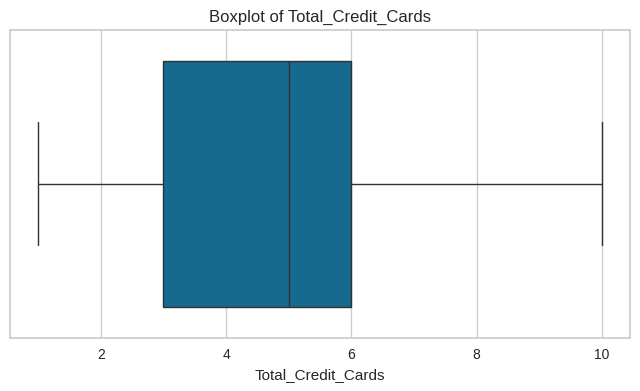

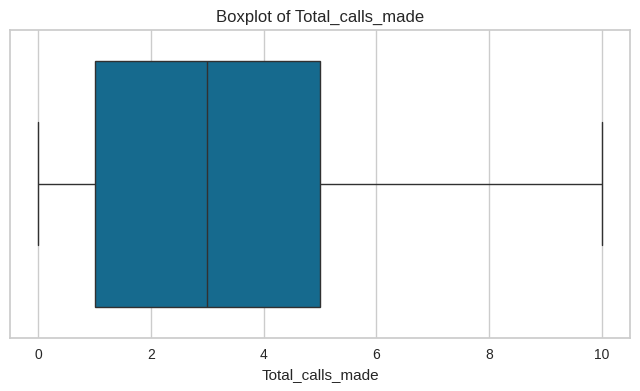

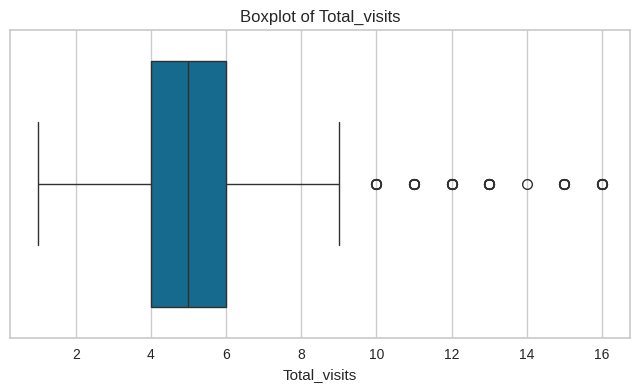

In [33]:
for col in da[num_col].columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=da, x=da[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [34]:
da_outliers = da[['Avg_Credit_Limit','Total_visits']]

In [35]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the number of outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Example: Checking for outliers in `Avg_Credit_Limit`
outliers = find_outliers_iqr(da, 'Avg_Credit_Limit')
print(f"Number of outliers in 'Avg_Credit_Limit': {len(outliers)}")
outliers1 = find_outliers_iqr(da, 'Total_visits')
print(f"Number of outliers in 'Total_visits': {len(outliers1)}")

Number of outliers in 'Avg_Credit_Limit': 39
Number of outliers in 'Total_visits': 36


In [36]:
Q1_col1 = da['Avg_Credit_Limit'].quantile(0.25)
Q3_col1 = da['Avg_Credit_Limit'].quantile(0.75)
IQR_col1 = Q3_col1 - Q1_col1

# Calculate lower and upper bounds for col1
lower_bound_col1 = Q1_col1 - 1.5 * IQR_col1
upper_bound_col1 = Q3_col1 + 1.5 * IQR_col1

# Calculate IQR for col2
Q1_col2 = da['Total_visits'].quantile(0.25)
Q3_col2 = da['Total_visits'].quantile(0.75)
IQR_col2 = Q3_col2 - Q1_col2

# Calculate lower and upper bounds for col2
lower_bound_col2 = Q1_col2 - 1.5 * IQR_col2
upper_bound_col2 = Q3_col2 + 1.5 * IQR_col2

# Clip the values in col1 and col2
da['Avg_Credit_Limit'] = np.clip(da['Avg_Credit_Limit'], lower_bound_col1, upper_bound_col1)
da['Total_visits'] = np.clip(da['Total_visits'], lower_bound_col2, upper_bound_col2)


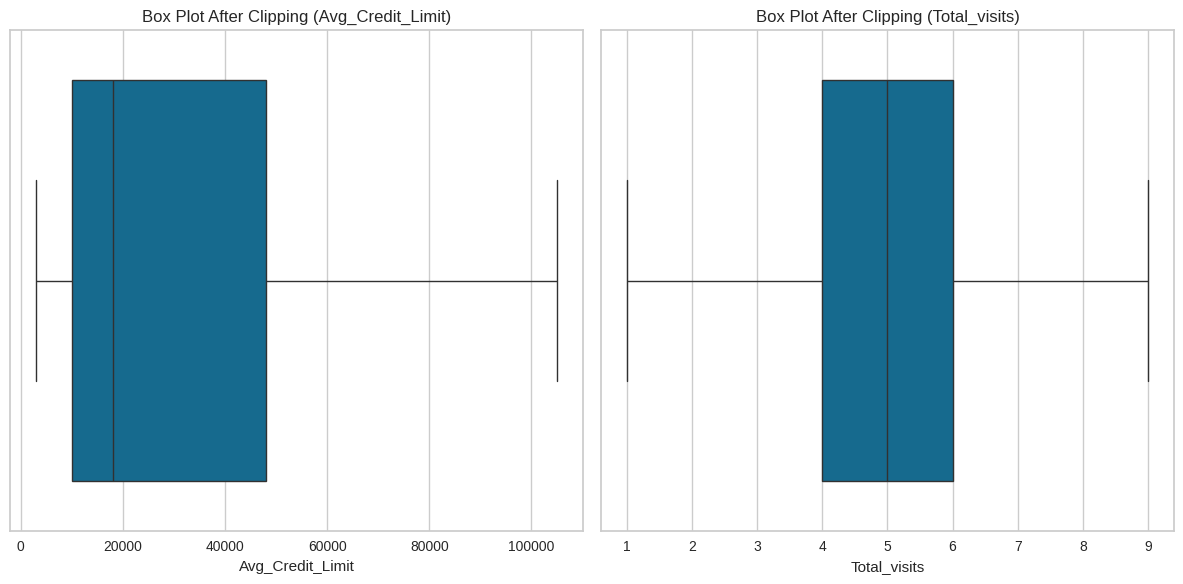

In [37]:
plt.figure(figsize=(12, 6))

# Box plot for col1 after clipping
plt.subplot(1, 2, 1)
sns.boxplot(x=da['Avg_Credit_Limit'])
plt.title('Box Plot After Clipping (Avg_Credit_Limit)')

# Box plot for col2 after clipping
plt.subplot(1, 2, 2)
sns.boxplot(x=da['Total_visits'])
plt.title('Box Plot After Clipping (Total_visits)')

plt.tight_layout()
plt.show()

In [38]:
#sclaeing the data

In [39]:
num_col1 = da.select_dtypes(include=np.number).columns.tolist()

In [40]:
scaler = StandardScaler()
subset = da[num_col1].copy()
subset_scaled = scaler.fit_transform(subset)

In [41]:
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [42]:
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits
0,2.398942,-1.249225,-1.251537,-1.564742
1,0.643619,-0.787585,1.891859,2.351351
2,0.643619,1.058973,0.145528,-0.445858
3,-0.058511,0.135694,0.145528,-1.564742
4,2.398942,0.597334,-0.203739,2.351351
...,...,...,...,...
655,2.363835,2.443892,-1.251537,2.351351
656,1.837238,2.443892,-0.553005,2.351351
657,2.574474,1.520613,-0.902271,2.351351
658,2.574474,2.443892,-1.251537,2.351351


In [43]:
da.head()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits
0,1,100000,2,0,2
1,2,50000,3,9,9
2,3,50000,7,4,4
3,4,30000,5,4,2
4,5,100000,6,3,9


In [44]:
km_df = da.copy()
hc_df = da.copy()

In [45]:
#k-mean clustering

Number of Clusters: 1 	Average Distortion: 1.8252706448332185
Number of Clusters: 2 	Average Distortion: 1.4187887499434253
Number of Clusters: 3 	Average Distortion: 1.1782869577262096
Number of Clusters: 4 	Average Distortion: 1.1159057790016225
Number of Clusters: 5 	Average Distortion: 1.0000343333932171
Number of Clusters: 6 	Average Distortion: 0.9425016484687111
Number of Clusters: 7 	Average Distortion: 0.8843375277282296
Number of Clusters: 8 	Average Distortion: 0.882113750888605
Number of Clusters: 9 	Average Distortion: 0.8301792597267995
Number of Clusters: 10 	Average Distortion: 0.8065403734169844
Number of Clusters: 11 	Average Distortion: 0.7926751934488254


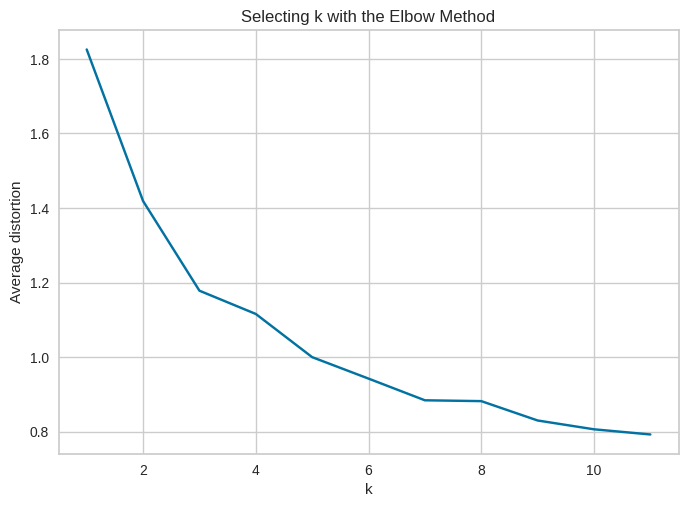

In [46]:
clusters = range(1, 12)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

For n_clusters = 2, the silhouette score is 0.437568290370672)
For n_clusters = 3, the silhouette score is 0.40672373421538144)
For n_clusters = 4, the silhouette score is 0.3328191924721258)
For n_clusters = 5, the silhouette score is 0.32934867831340886)
For n_clusters = 6, the silhouette score is 0.31242344969386315)
For n_clusters = 7, the silhouette score is 0.28055818907333485)
For n_clusters = 8, the silhouette score is 0.2809790438553698)
For n_clusters = 9, the silhouette score is 0.27232531344205974)
For n_clusters = 10, the silhouette score is 0.26214311448441363)
For n_clusters = 11, the silhouette score is 0.25554914281246055)


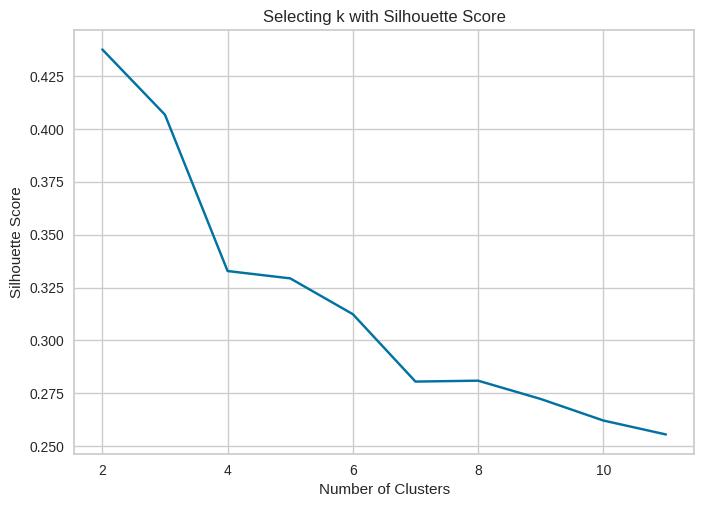

In [47]:
sil_score = []
cluster_list = range(2, 12)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.title('Selecting k with Silhouette Score')  # Add title here
plt.xlabel('Number of Clusters')  # Optional: Add x-axis label
plt.ylabel('Silhouette Score')  # Optional: Add y-axis label
plt.show()

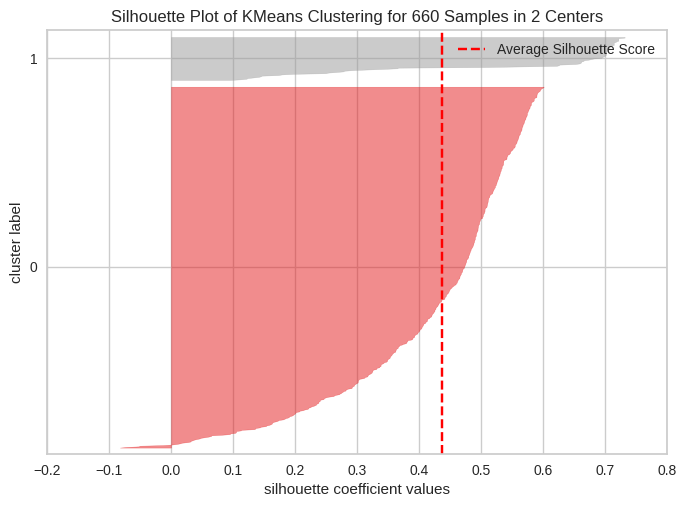

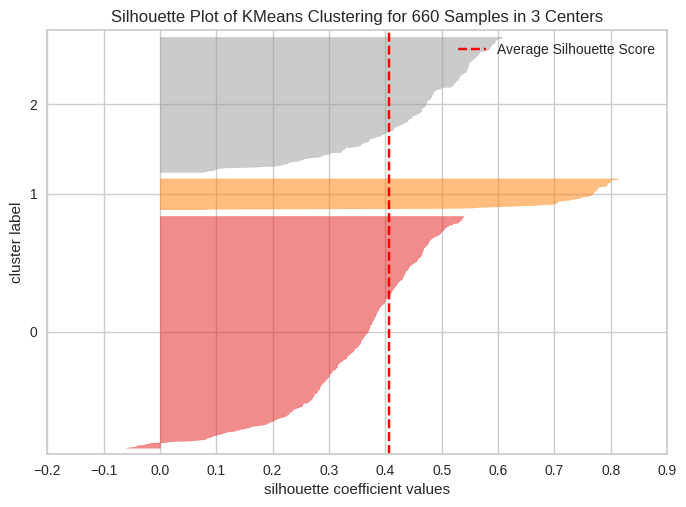

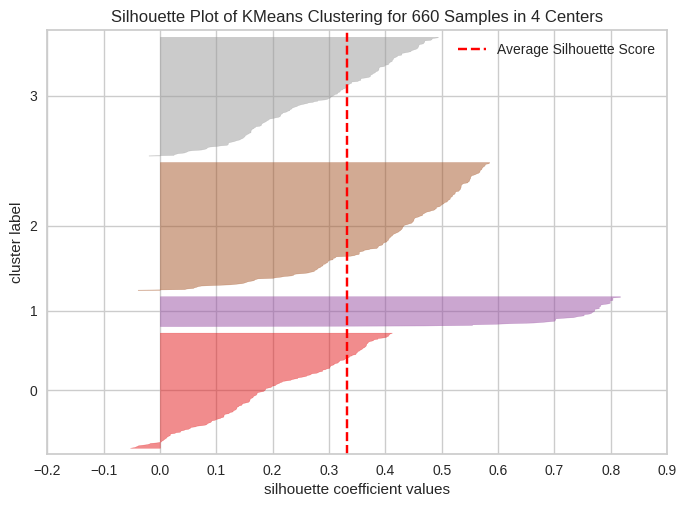

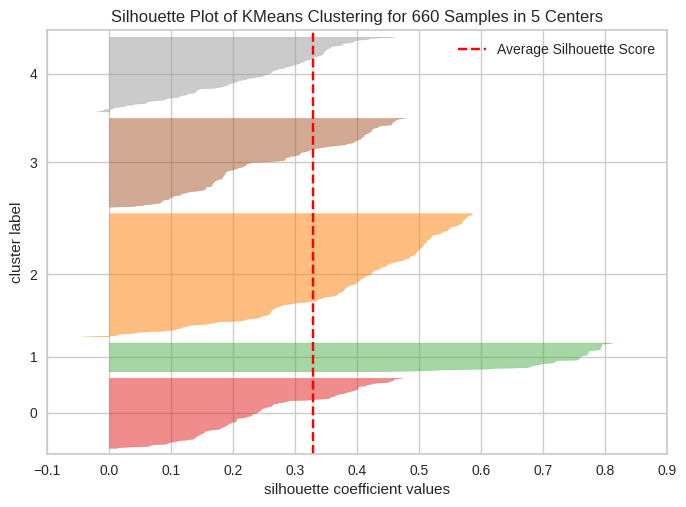

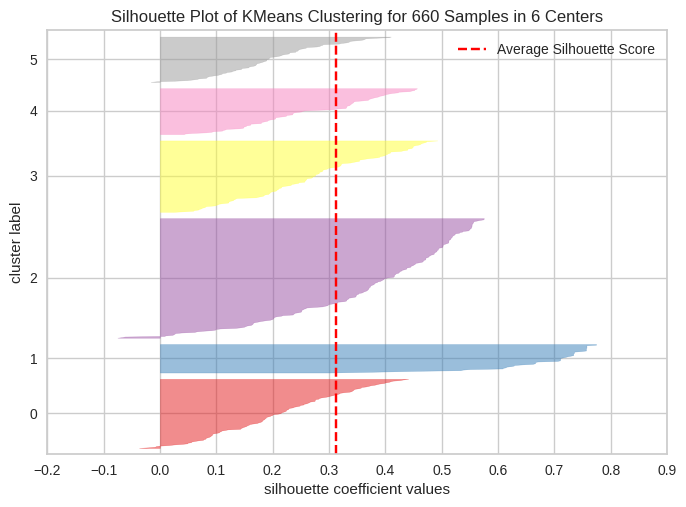

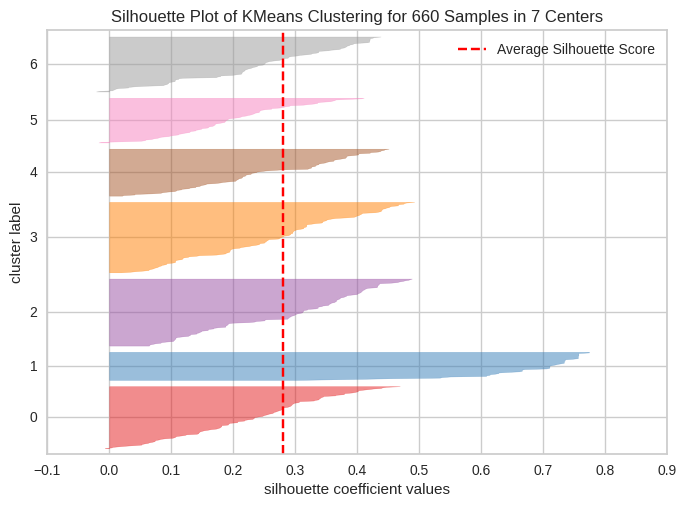

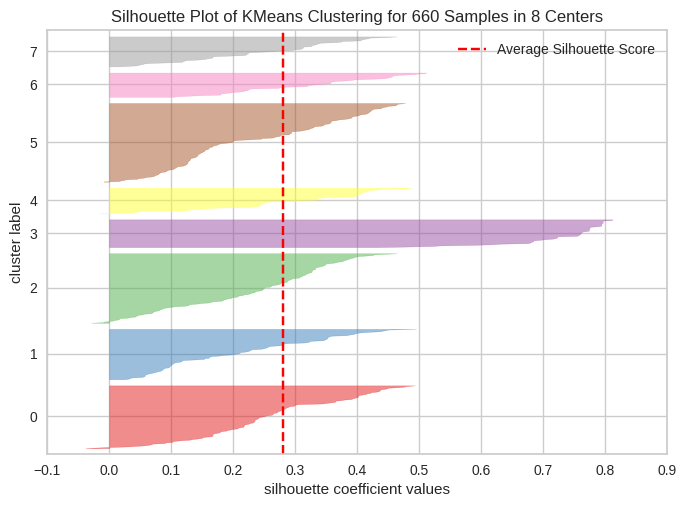

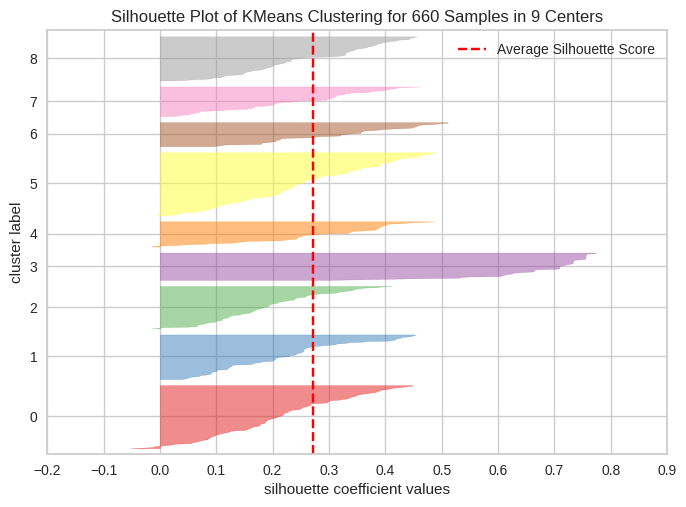

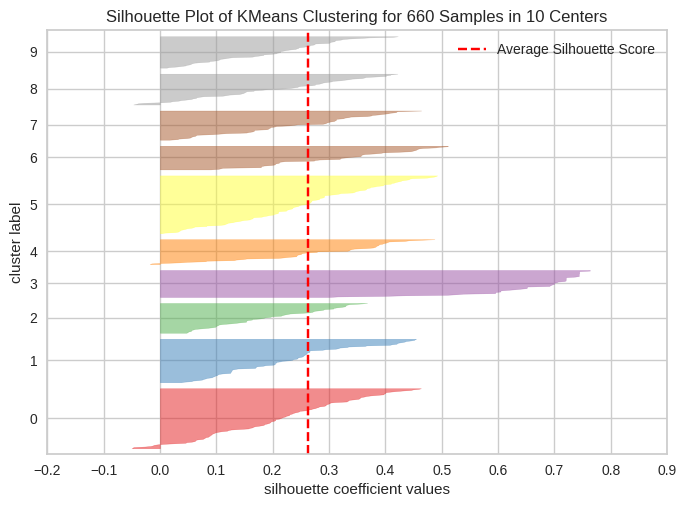

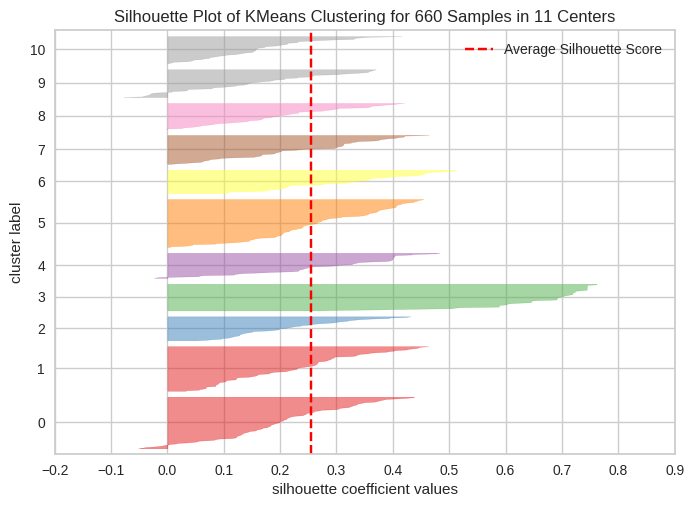

In [48]:
for n_clusters in range(2, 12):
    visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state=1))
    visualizer.fit(subset_scaled_df)
    visualizer.show()

In [49]:
#We will proceed with k=7

In [50]:
kmeans = KMeans(n_clusters=7, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=7, random_state=1)

In [51]:
km_df["KM_segments"] = kmeans.labels_
subset_scaled_df["KM_segments"] = kmeans.labels_

In [52]:
km_df

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,KM_segments
0,1,100000,2,0,2,4
1,2,50000,3,9,9,2
2,3,50000,7,4,4,4
3,4,30000,5,4,2,0
4,5,100000,6,3,9,1
...,...,...,...,...,...,...
655,656,99000,10,0,9,1
656,657,84000,10,2,9,1
657,658,105000,8,1,9,1
658,659,105000,10,0,9,1


In [53]:
da

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits
0,1,100000,2,0,2
1,2,50000,3,9,9
2,3,50000,7,4,4
3,4,30000,5,4,2
4,5,100000,6,3,9
...,...,...,...,...,...
655,656,99000,10,0,9
656,657,84000,10,2,9
657,658,105000,8,1,9
658,659,105000,10,0,9


In [54]:
#Cluster Profiling: K-means Clustering

In [55]:
km_df_profiling  = km_df.groupby("KM_segments").mean(numeric_only = True)

In [56]:
km_df_profiling ["count_in_each_segments"] = (
    km_df.groupby("KM_segments")["Avg_Credit_Limit"].count().values
)

In [57]:
km_df_profiling .style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,count_in_each_segments
KM_segments,,,,,
0,19100.917431,5.752294,1.798165,3.330275,109
1,102660.000000,8.740000,1.080000,8.720000,50
2,12525.423729,2.372881,7.635593,5.432203,118
3,15588.709677,5.064516,2.290323,5.741935,124
4,58807.228916,5.397590,2.265060,3.168675,83
5,53924.050633,5.784810,1.772152,5.569620,79
6,11680.412371,2.360825,6.206186,3.206186,97


In [58]:
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,KM_segments
0,2.398942,-1.249225,-1.251537,-1.564742,4
1,0.643619,-0.787585,1.891859,2.351351,2
2,0.643619,1.058973,0.145528,-0.445858,4
3,-0.058511,0.135694,0.145528,-1.564742,0
4,2.398942,0.597334,-0.203739,2.351351,1
...,...,...,...,...,...
655,2.363835,2.443892,-1.251537,2.351351,1
656,1.837238,2.443892,-0.553005,2.351351,1
657,2.574474,1.520613,-0.902271,2.351351,1
658,2.574474,2.443892,-1.251537,2.351351,1


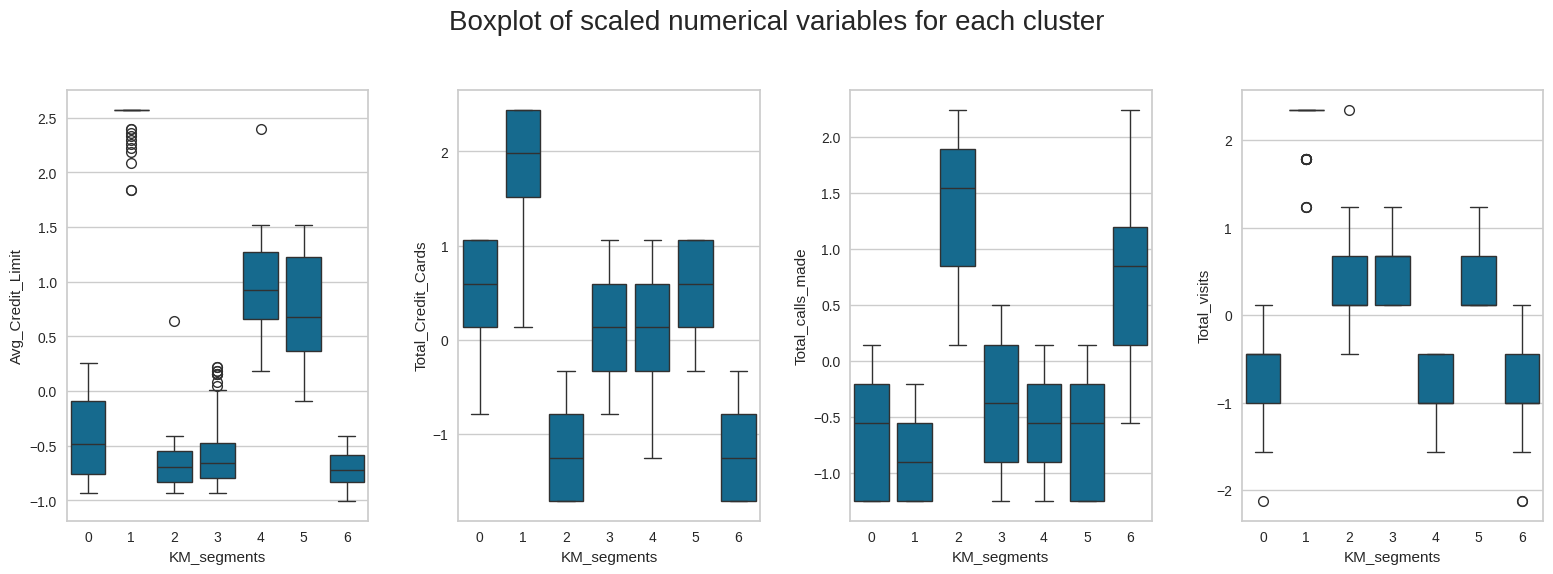

In [59]:
fig, axes = plt.subplots(1, len(num_col), figsize=(16, 6))  # Adjust subplot count to match num_col
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)

for ii, col in enumerate(num_col):  # Use enumerate for clarity
    sns.boxplot(ax=axes[ii], y=subset_scaled_df[col], x=subset_scaled_df["KM_segments"])

fig.tight_layout(pad=2.0)

In [60]:
#Hierarchical Clustering

In [61]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7870991907057644.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7881389828953572.
Cophenetic correlation for Euclidean distance and average linkage is 0.8246848004117399.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.752658989727627.
Cophenetic correlation for Chebyshev distance and single linkage is 0.727581951591062.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.6668212198009127.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8052078815573276.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.7083476360512566.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7091673391866236.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5169849145877954.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7563106293214741.
Cophenetic corr

In [62]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8246848004117399, which is obtained with Euclidean distance and average linkage.


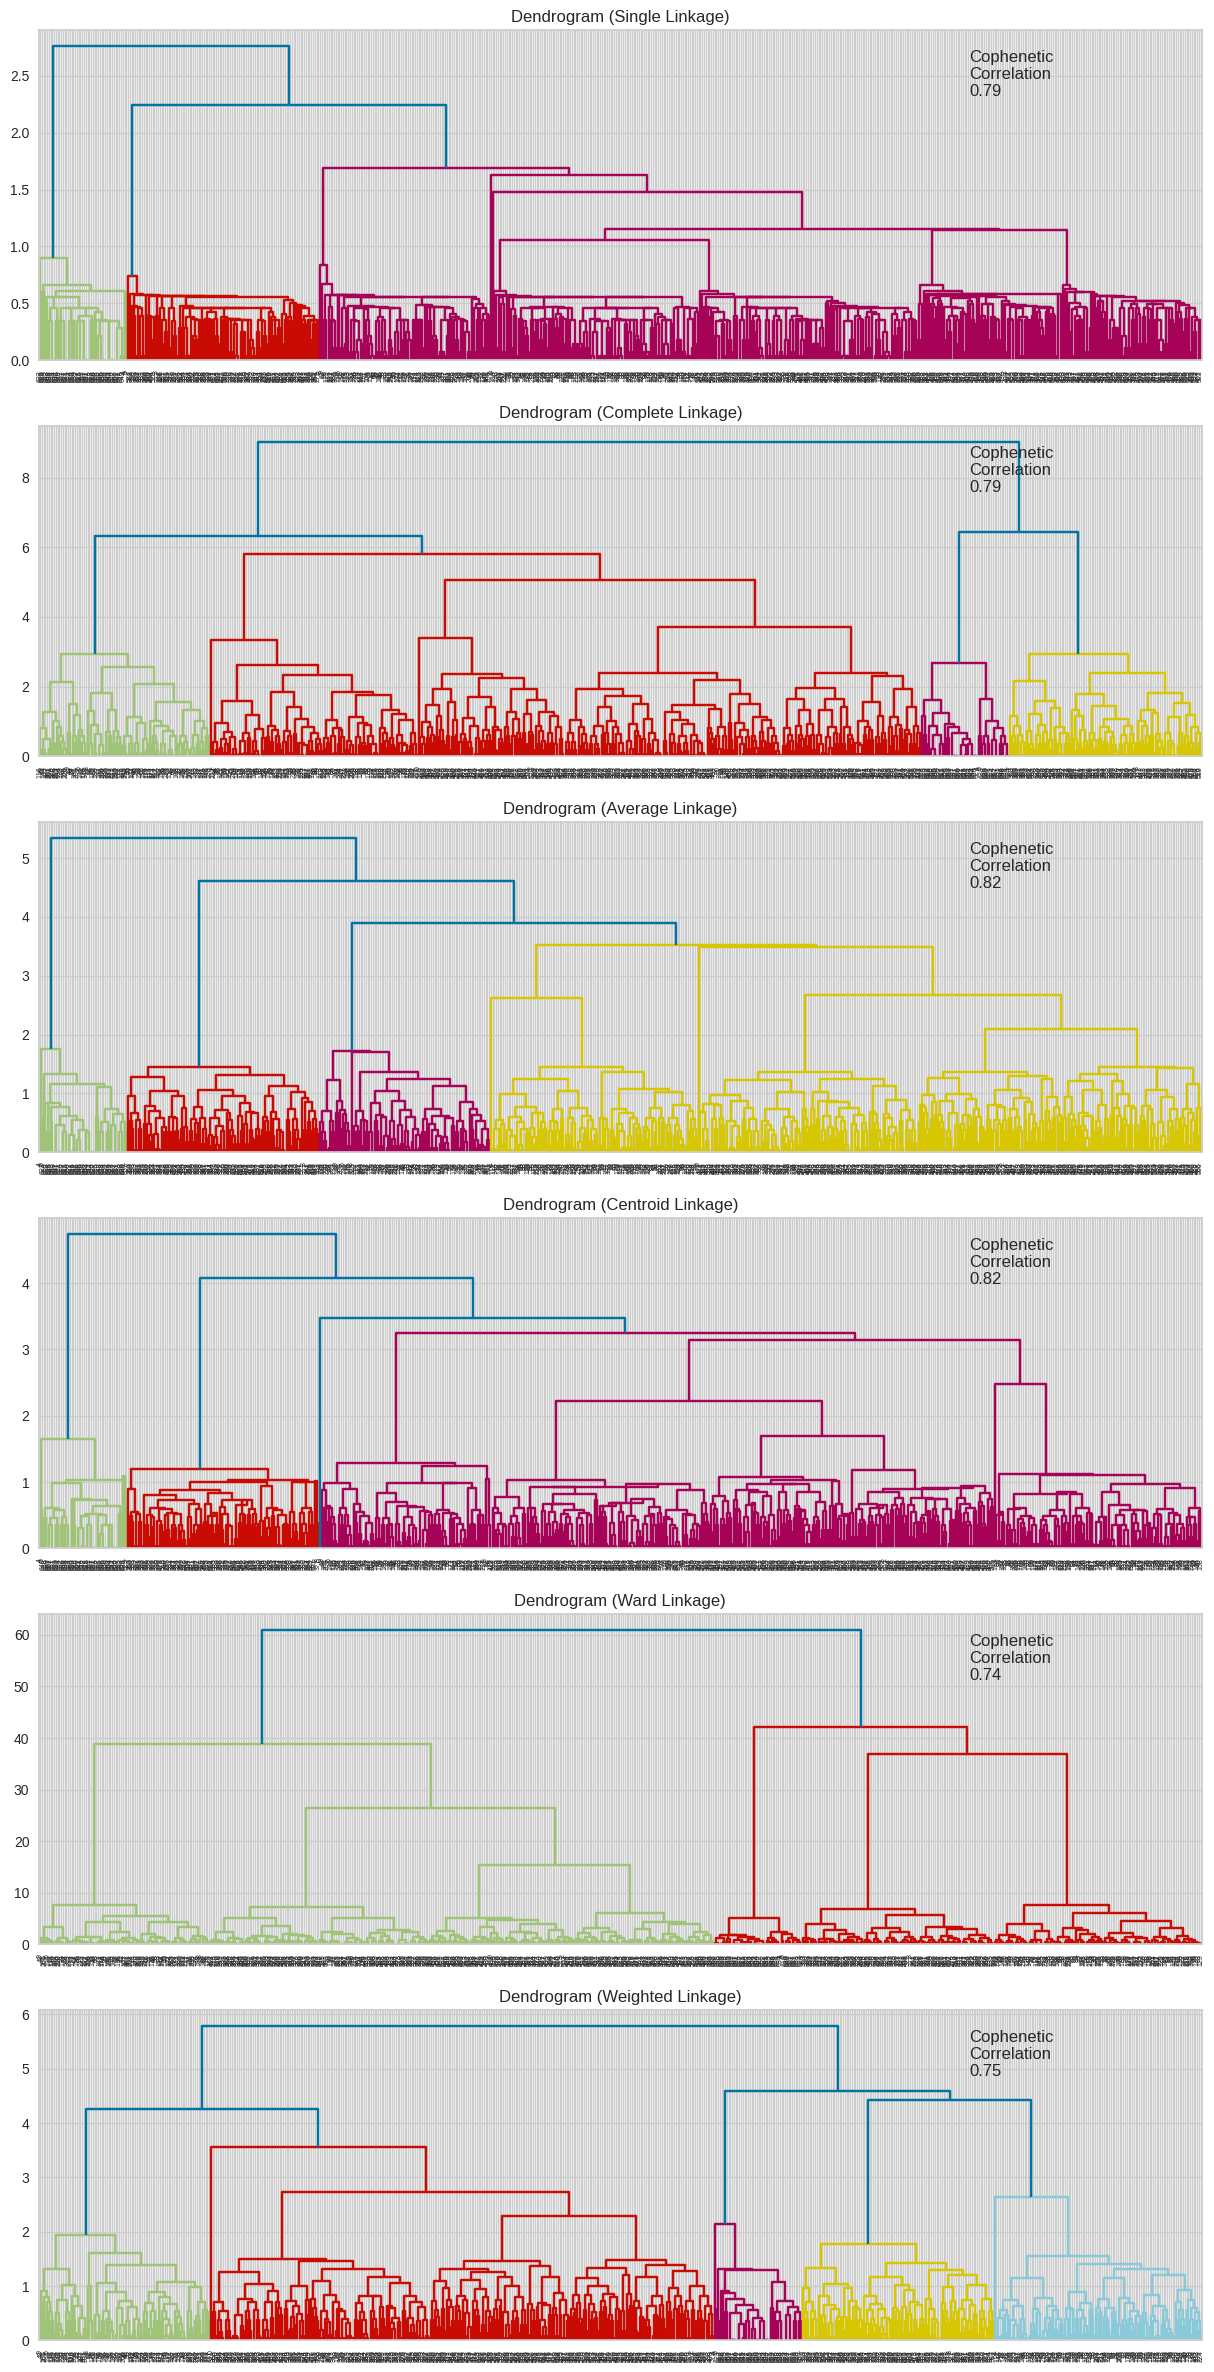

In [63]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [64]:
hc = AgglomerativeClustering(n_clusters=7, metric="euclidean", linkage="ward")
hc_labels = hc.fit_predict(subset_scaled_df)

In [65]:
hc_df["HC_segments"] = hc_labels

subset_scaled_df["HC_segments"] = hc_labels

In [66]:
#Cluster Profiling - Hierarchical Clustering

In [67]:
cluster_profile_c = hc_df.groupby("HC_segments").mean(numeric_only = True)
cluster_profile_c["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

# displaying the group-wise means of variables
cluster_profile_c.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,count_in_each_segment
HC_segments,,,,,
0,12525.423729,2.372881,7.635593,5.432203,118
1,11680.412371,2.360825,6.206186,3.206186,97
2,15588.709677,5.064516,2.290323,5.741935,124
3,53924.050633,5.784810,1.772152,5.569620,79
4,19100.917431,5.752294,1.798165,3.330275,109
5,102660.000000,8.740000,1.080000,8.720000,50
6,58807.228916,5.397590,2.265060,3.168675,83


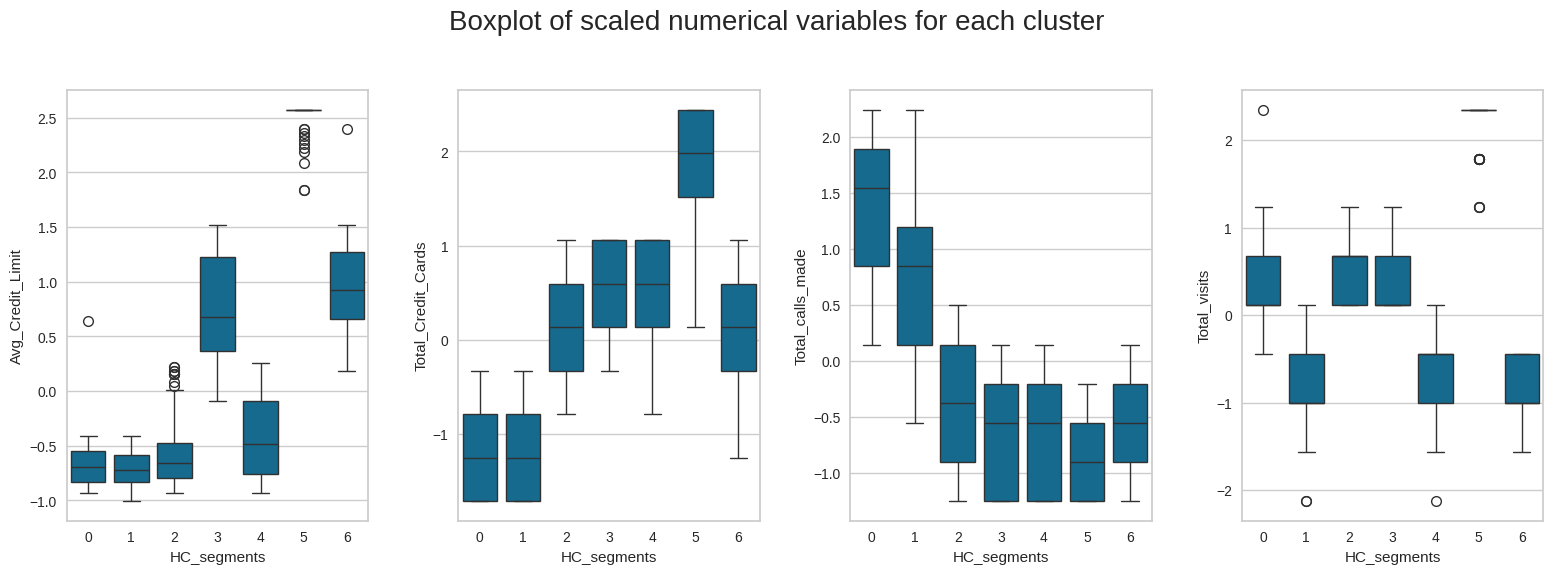

In [68]:
fig, axes = plt.subplots(1, len(num_col), figsize=(16, 6))  # Adjust subplot count to match num_col
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)

for ii, col in enumerate(num_col):  # Use enumerate for clarity
    sns.boxplot(ax=axes[ii], y=subset_scaled_df[col], x=subset_scaled_df["HC_segments"])

fig.tight_layout(pad=2.0)

In [69]:
#cfross verification

In [70]:
print(kmeans.fit_predict(subset_scaled_df))


[3 2 3 0 5 4 5 0 4 4 6 4 2 2 2 2 4 4 4 2 2 4 2 4 4 2 2 2 4 4 6 2 2 2 2 4 2
 4 2 2 2 4 6 4 6 2 4 4 4 4 2 2 2 2 2 4 4 4 4 2 2 2 4 4 2 4 4 4 2 2 2 4 4 4
 2 2 2 6 2 4 2 2 4 2 2 2 4 4 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2 4 4 2 2 4 4 2 6
 2 2 4 4 2 4 4 2 2 2 2 4 2 2 2 2 2 6 2 2 4 4 2 2 2 4 2 2 4 4 4 2 2 2 4 2 2
 2 4 2 4 4 4 2 2 2 2 2 4 4 2 4 2 4 2 4 2 2 2 4 2 2 2 4 4 4 4 2 4 4 4 4 2 4
 4 4 2 4 2 2 4 4 2 4 2 4 4 2 2 4 4 4 4 2 2 4 6 4 4 2 6 4 4 2 4 6 4 2 2 4 2
 2 2 2 4 2 2 0 0 6 6 6 0 6 0 6 0 0 0 0 6 6 6 6 0 6 0 6 6 0 0 6 0 0 6 0 6 6
 6 6 0 6 0 6 6 0 0 6 6 6 0 0 6 6 0 6 6 6 6 6 0 0 0 0 6 6 0 0 6 0 6 4 0 6 6
 0 0 6 6 6 6 0 6 6 6 0 6 6 6 6 0 0 4 0 0 0 6 0 0 6 6 0 0 6 6 6 6 6 6 0 6 0
 6 6 6 6 0 0 0 0 6 6 6 0 6 0 0 6 6 0 0 0 6 0 6 6 6 0 0 0 0 6 0 6 6 6 6 0 6
 6 0 6 6 6 0 6 0 6 0 0 0 6 0 0 6 0 0 6 6 4 6 0 0 0 6 1 1 3 3 1 3 3 1 3 3 3
 3 3 3 3 1 6 1 3 1 3 1 3 3 1 1 3 3 6 3 3 1 3 1 3 1 3 1 3 1 3 3 0 3 3 0 3 1
 1 1 3 3 6 6 1 6 1 3 0 3 1 3 3 1 6 6 3 6 3 1 3 6 6 3 6 1 0 0 3 1 1 1 1 1 3
 0 3 6 6 1 3 1 3 1 3 1 1 

In [71]:
print(hc.fit_predict(subset_scaled_df))


[3 0 3 4 5 1 5 4 1 1 2 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 2 0 0 0 0 1 0
 1 0 0 0 1 2 1 2 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1
 0 0 0 2 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 2
 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 2 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0
 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 2 1 1 0 2 1 1 0 1 2 1 0 0 1 0
 0 0 0 1 0 0 4 4 2 2 2 4 2 4 2 4 4 4 4 2 2 2 2 4 2 4 2 2 4 4 2 4 4 2 4 2 2
 2 2 4 2 4 2 2 4 4 2 2 2 4 4 2 2 4 2 2 2 2 2 4 4 4 4 2 2 4 4 2 4 2 1 4 2 2
 4 4 2 2 2 2 4 2 2 2 4 2 2 2 2 4 4 1 4 4 4 2 4 4 2 2 4 4 2 2 2 2 2 2 4 2 4
 2 2 2 2 4 4 4 4 2 2 2 4 2 4 4 2 2 4 4 4 2 4 2 2 2 4 4 4 4 2 4 2 2 2 2 4 2
 2 4 2 2 2 4 2 4 2 4 4 4 2 4 4 2 4 4 2 2 1 2 4 4 4 2 6 6 3 3 6 3 3 6 3 3 3
 3 3 3 3 6 2 6 3 6 3 6 3 3 6 6 3 3 2 3 3 6 3 6 3 6 3 6 3 6 3 3 4 3 3 4 3 6
 6 6 3 3 2 2 6 2 6 3 4 3 6 3 3 6 2 2 3 2 3 6 3 2 2 3 2 6 4 4 3 6 6 6 6 6 3
 4 3 2 2 6 3 6 3 6 3 6 6 

In [72]:
km_labels = km_df["KM_segments"].values  # Get K-means labels
hc_labels = hc_df["HC_segments"].values  # Get Hierarchical labels

# Check if the labels are identical
comparison = pd.Series(km_labels == hc_labels)
print(comparison.value_counts())

False    660
Name: count, dtype: int64


In [73]:
print(km_df.info())  # Verify K-means DataFrame structure
print(hc_df.info())  # Verify Hierarchical DataFrame structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Sl_No               660 non-null    category
 1   Avg_Credit_Limit    660 non-null    int64   
 2   Total_Credit_Cards  660 non-null    int64   
 3   Total_calls_made    660 non-null    int64   
 4   Total_visits        660 non-null    int64   
 5   KM_segments         660 non-null    int32   
dtypes: category(1), int32(1), int64(4)
memory usage: 45.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Sl_No               660 non-null    category
 1   Avg_Credit_Limit    660 non-null    int64   
 2   Total_Credit_Cards  660 non-null    int64   
 3   Total_calls_made    660 non-null    int64   
 4   Total_visits        

In [74]:
kmeans = KMeans(n_clusters=7, random_state=1)
km_labels = kmeans.fit_predict(subset_scaled_df)

# Store results in a dedicated dataframe
km_df = subset.copy()  # Use a copy of the original data
km_df["KM_segments"] = km_labels

In [75]:
hc = AgglomerativeClustering(n_clusters=7, metric="euclidean", linkage="ward")
hc_labels = hc.fit_predict(subset_scaled_df)

# Store results in a separate dataframe
hc_df = subset.copy()  # Use a copy of the original data
hc_df["HC_segments"] = hc_labels

In [76]:
print("K-means Profiling Table:")
print(km_df.groupby("KM_segments").mean())

print("Hierarchical Clustering Profiling Table:")
print(hc_df.groupby("HC_segments").mean())

K-means Profiling Table:
             Avg_Credit_Limit  Total_Credit_Cards  Total_calls_made  \
KM_segments                                                           
0                19100.917431            5.752294          1.798165   
1                53924.050633            5.784810          1.772152   
2                12525.423729            2.372881          7.635593   
3                58807.228916            5.397590          2.265060   
4                11680.412371            2.360825          6.206186   
5               102660.000000            8.740000          1.080000   
6                15588.709677            5.064516          2.290323   

             Total_visits  
KM_segments                
0                3.330275  
1                5.569620  
2                5.432203  
3                3.168675  
4                3.206186  
5                8.720000  
6                5.741935  
Hierarchical Clustering Profiling Table:
             Avg_Credit_Limit  Total_Credi

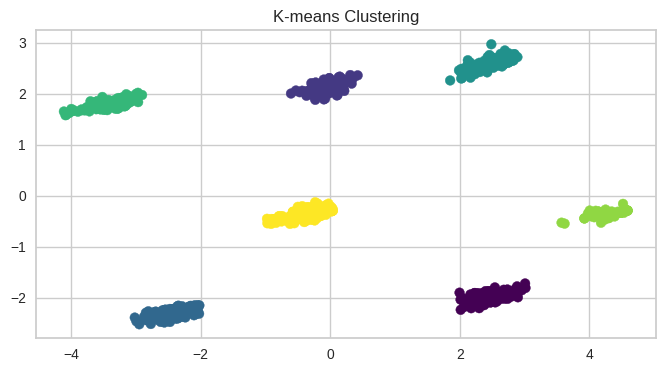

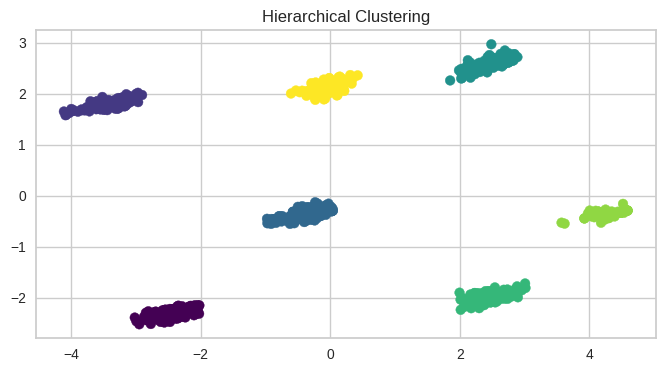

In [77]:

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(subset_scaled_df)

# Plot K-means clusters
plt.figure(figsize=(8, 4))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=km_labels, cmap='viridis', label="K-means")
plt.title("K-means Clustering")
plt.show()

# Plot Hierarchical clusters
plt.figure(figsize=(8, 4))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hc_labels, cmap='viridis', label="Hierarchical")
plt.title("Hierarchical Clustering")
plt.show()

In [78]:
# K-means vs Hierarchical Clustering

In [79]:
km_df_profiling.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,count_in_each_segments
KM_segments,,,,,
0,19100.917431,5.752294,1.798165,3.330275,109
1,102660.000000,8.740000,1.080000,8.720000,50
2,12525.423729,2.372881,7.635593,5.432203,118
3,15588.709677,5.064516,2.290323,5.741935,124
4,58807.228916,5.397590,2.265060,3.168675,83
5,53924.050633,5.784810,1.772152,5.569620,79
6,11680.412371,2.360825,6.206186,3.206186,97


In [80]:
cluster_profile_c.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_calls_made,Total_visits,count_in_each_segment
HC_segments,,,,,
0,12525.423729,2.372881,7.635593,5.432203,118
1,11680.412371,2.360825,6.206186,3.206186,97
2,15588.709677,5.064516,2.290323,5.741935,124
3,53924.050633,5.784810,1.772152,5.569620,79
4,19100.917431,5.752294,1.798165,3.330275,109
5,102660.000000,8.740000,1.080000,8.720000,50
6,58807.228916,5.397590,2.265060,3.168675,83


In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(subset_scaled_df)

# storing results in a dataframe
reduced_data_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

# checking the amount of variance explained
print(
    f"The first two principal components explain {np.round(100*pca.explained_variance_ratio_.sum(), 2)}% of the variance in the data."
)

The first two principal components explain 80.71% of the variance in the data.


Text(0.5, 1.0, 'PCA Scatter Plot: Visualizing Data Structure')

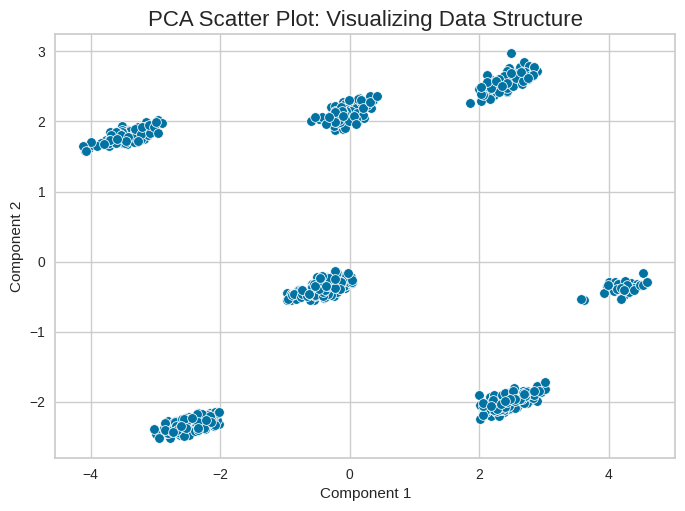

In [82]:
sns.scatterplot(data=reduced_data_df_pca, x="Component 1", y="Component 2")
plt.title("PCA Scatter Plot: Visualizing Data Structure", fontsize=16)

Text(0.5, 1.0, 'PCA Scatter Plot with Hierarchical Clustering Labels')

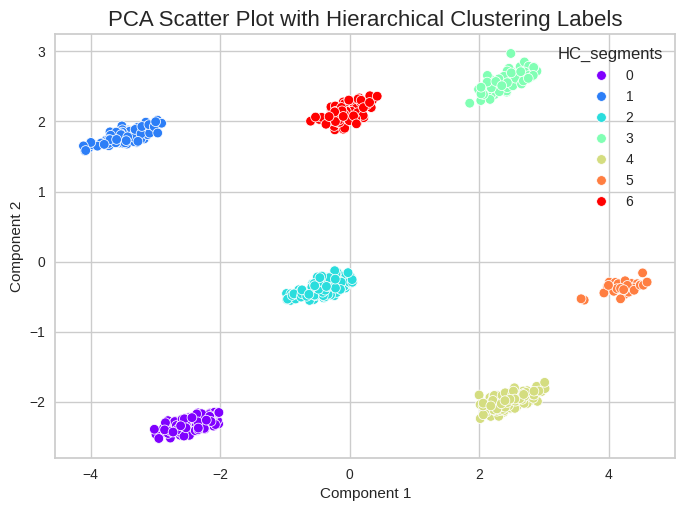

In [85]:
sns.scatterplot(
    data=reduced_data_df_pca,
    x="Component 1",
    y="Component 2",
    hue=hc_df["HC_segments"],  # Assuming 'hc_df' contains the clustering labels
    palette="rainbow"
)

# Add the heading title
plt.title("PCA Scatter Plot with Hierarchical Clustering Labels", fontsize=16)